In [1]:
import xml.etree.cElementTree as ET
import re
import sqlite3
import pandas as pd
import csv
import os
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt

## MAP AREA

- Country: Vietnam
- City: Saigon
- Data avaiable at: https://mapzen.com/data/metro-extracts/metro/ho-chi-minh-city_vietnam/
- Additional note: Ho Chi Minh is the current name of the city. However, I prefer the name Saigon, therefore I shall use it in my analysis.

In [ ]:
Image(filename = "saigon.JPG")

## THE DATA

- Size: 5.4 MB compressed, 69.6 MB uncompressed
- Contents: The data contain 3 types of blocks: nodes, ways and relations. 

   + Nodes: single point in space defined by its latitude, longitude and node id.

   + Ways: an ordered list of nodes which normally also has at least one tag or is included within a Relation.

   + Relations: A relation is one of the core data elements that consists of one or more tags and also an ordered list of one or more nodes, ways and/or relations as members which is used to define logical or geographic relationships between other elements.

- Encoding: 'utf-8', since Python's default encoding 'ascii' doesn't provide support for the type of language encountered. 

- The scope of this project are limited to nodes and ways.

In [ ]:
# If you are running this locally, remember to change the path
saigon_osm = 'ho-chi-minh-city_vietnam_Short1.osm'

## DATA TABLES

#### 1. TABLE NODES:

    - id INTEGER NOT NULL
    - lat REAL
    - lon REAL
    - user UNICODE
    - uid INTEGER
    - version INTEGER
    - changeset INTEGER
    - timestamp STR

In [ ]:
# If not none, convert the default string inputs to a specified type.
def type_data(stringin, type):
    if stringin:
        return type(stringin)

# If not none, encode the string input to utf-8
def string_encode(stringin):
    if stringin:
        return stringin.encode('utf-8')

# Read the osm file, convert the data to pre-specified type. 
# Return a list of dictionaries containing fields accordingly to table nodes.
def nodes_data(file_in):
    data_node = []
    with open(file_in, 'r') as osm:
        for _, element in ET.iterparse(file_in):
            if element.tag == 'node' and element.get('id'):                    
                node = {}
                node['id'] = type_data(element.get('id'), int)
                node['lat'] = type_data(element.get('lat'), float)
                node['lon'] = type_data(element.get('lon'), float)
                node['user'] = string_encode(element.get('user'))
                node['uid'] = type_data(element.get('uid'), int)
                node['version'] = type_data(element.get('version'), int)
                node['changeset'] = type_data(element.get('changeset'), int)
                node['timestamp'] = type_data(element.get('timestamp'), str)
                data_node.append(node)
    return data_node

nodes = nodes_data(saigon_osm)

#### 2. TABLE NODES_TAGS:

    - id INTEGER PRIMARY KEY NOT NULL
    - key INTEGER
    - value 
    - type STR

In [ ]:
# If the input is not none, identify the type that the input should be
# (between int, float and string), convert the input accordingly
# while encode the string with utf-8.

def type_ident(stringin):
    re_float = re.compile(r'^(\d+|\-\d+)(\.|\,)(\d+(e|E)\+)?\d+$')
    re_int = re.compile(r'^\-?\d+$')
    if stringin:
        if re_float.match(stringin):
            try:
                return float(stringin)
            except ValueError:
                return float(stringin.replace(",","."))
        else:
            if re_int.match(stringin):
                return int(stringin)
            else:
                return stringin.encode('utf-8')
            
# Read the osm file, convert the data to pre-specified type.
# If not specified, then identify the type and convert it accordingly.
# Return a list of dictionaries containing fields accordingly to table nodes_tags.   
def nodes_tags_data(file_in, block):
    data = []
    with open(file_in, 'r') as osm:
        for _, element in ET.iterparse(file_in):
            if element.tag == block:
                for tag in element.iter('tag'):
                    node_tag = {}
                    node_tag['id'] = type_data(element.get('id'), int)
                    node_tag['key'] = string_encode(tag.attrib.get('k'))
                    node_tag['value'] = type_ident(tag.attrib.get('v'))
                    node_tag['type'] = type(node_tag['value']).__name__
                    data.append(node_tag)
    return data
            

nodes_tags = nodes_tags_data(saigon_osm, 'node')

#### 3. TABLE WAYS:

    - id INTEGER NOT NULL
    - user UNICODE
    - uid INTEGER
    - version INTEGER
    - changeset INTEGER
    - timestamp STR

In [ ]:
# Read the osm file, convert the data to pre-specified type. 
# Return a list of dictionaries containing fields accordingly to table ways.
def ways_data(file_in):
    data_node = []
    with open(file_in, 'r') as osm:
        for _, element in ET.iterparse(file_in):
            if element.tag == 'way' and element.get('id'):
                node = {}
                node['id'] = type_data(element.get('id'), int)
                node['user'] = string_encode(element.get('user'))
                node['uid'] = type_data(element.get('uid'), int)
                node['version'] = type_data(element.get('version'), int)
                node['changeset'] = type_data(element.get('changeset'), int)
                node['timestamp'] = type_data(element.get('timestamp'), str)
                data_node.append(node)
    return data_node

ways = ways_data(saigon_osm)

#### 4. TABLE WAYS_TAGS:

    - id INTEGER NOT NULL
    - key UNICODE
    - value 
    - type STR

In [ ]:
# Read the osm file, convert the data to pre-specified type. 
# Return a list of dictionaries containing fields accordingly to table ways_tags.
def ways_tags_data(file_in):
    data = []
    with open(file_in, 'r') as osm:
        for _, element in ET.iterparse(file_in):
            if element.tag == 'way':
                for tag in element.iter('tag'):
                    if element.get('id') and tag.attrib.get('k') and tag.attrib.get('v'):
                        node_tag = {}
                        node_tag['id'] = type_data(element.get('id'), int)
                        node_tag['key'] = string_encode(tag.attrib.get('k'))
                        node_tag['value'] = type_ident(tag.attrib.get('v'))
                        node_tag['type'] = type(node_tag['value']).__name__
                        data.append(node_tag)
    return data

ways_tags = ways_tags_data(saigon_osm)

#### 5. TABLE WAYS_NODES:

Position is a list containing latitude and longtitude data of individual node. I could get them right now, but it will be kinda taxing, so I'll only create a temporary table here to store the needed 'id' and 'node_id'.
The position data will be added later on using sqlite.

    - id INTEGER NOT NULL,
    - node_id INTEGER NOT NULL,
    - position INTEGER NOT NULL, 
    - FOREIGN KEY (id) REFERENCES ways(id),
    - FOREIGN KEY (node_id) REFERENCES nodes(id)

In [ ]:
# Read the osm file, convert the data to pre-specified type. 
# Return a list of dictionaries containing fields accordingly to table ways_tags.
def ways_nodes_data(file_in):
    data = []
    with open(file_in, 'r') as osm:
        for _, element in ET.iterparse(file_in):
            if element.tag == 'way':
                for tag in element.iter('nd'):
                    if element.get('id') and tag.attrib.get('ref'):
                        node_tag = {}
                        node_tag['id'] = type_data(element.get('id'), int)
                        node_tag['node_id'] = type_data(tag.attrib.get('ref'), int)
                        data.append(node_tag)
    return data

ways_nodes = ways_nodes_data(saigon_osm)


## PROBLEMS ENCOUNTERED:

1. Inconsistent name of district ("District 1", "1", "D1")
2. Inconsistent form of phone number (+8412345678, 012345678, 084012345678)

#### 1. DISTRICT:

So they have 2 naming patterns:
- Numeric pattern, where the name of the district is a number, e.x. '1'
- String pattern, where the name of the district is a string, e.x. 'Bình Thạnh'

The problem is, people have the urge, of adding the word 'district' to the name of the district, and they do just that:
- The common way of calling a district for numeric pattern is "District x".
- The string pattern, however, provide people with more freedom, resulting in several calling pattern:
      + "District x"
      + "x"

In addition, there are various short form of "District", in both Vietnamese and English.

So I will choose the simplest approach, I will remove all the district thingy, and leave only the name of that district. If people want, they could always add the word "district" later on.

In [ ]:
numerical_districts = [u'1', u'2', u'3', u'4', u'5', u'6', 
                       u'7', u'8', u'9', u'10', u'11', u'12']

string_districts = [u'Gò Vấp', u'Tân Bình', u'Tân Phú', u'Bình Thạnh', u'Phú Nhuận', u'Thủ Đức', 
                    u'Bình Tân', u'Củ Chi', u'Hóc Môn', u'Bình Chánh', u'Nhà Bè', u'Cần Giờ']

def clean_district(district):
    # Convert and encode the name of district
    if type(district).__name__ == 'int':
        district = unicode(district)
    if type(district).__name__ == 'str':
        district = unicode(district, 'utf-8')
    
    # Return the correct district name if the data match the correct district name.
    for district_name in string_districts:
        if district_name in district:
            return district_name
        # Try again, this time lower case and without white space.
        district_name_plain = district_name.lower().replace(' ', '')
        district_plain = district.lower().replace(' ', '')
        if district_name_plain in district_plain:
            return district_name        

    # If the district doesn't belong to string_districts, then try to match with numerical_districts
    for district_name in numerical_districts:
        if district_name in district:
            return district_name
    
    # If not, then the data might be wrong. But I don't know that, so I choosed to keep it like that.
    return district

#### 2. PHONE NUMBER:

I'm going to try converting all the phone numbers to the international standard E.164.
Since the country's code is +84, I do have the urge, of adding +84 to all the numbers at hand.
But it might not be a wise choice, since it might affect the integrity of the data set.
So I will just clean the data, while advoiding changes as best as I can:
    - Remove special chars (-/.), leaving only the comma (,) to seperate numbers (in case of more than one input).
    - Remove 0 around country code (+084, +840).
    - Remove 0 at the beginning of phone numbers (0912345678)

In [ ]:
#+0840917685464 (+848)38241534 84-8-38385584 (08)62738496
# While the international standard E.164 provide up to 15 digits, Vietnam have only used up to 12 digits.
def clean_number(number):
    number = str(number)
    number = number.replace(" ", "")
    number = number.replace(".", "")
    ideal_pattern = re.compile('^\+?[1-9]\d{1,12}$') # +84xxxxxxx or xxxxxxxx
    contain_0_beginning = re.compile('^0')
    
    # If the phone number is of ideal pattern, stop and return the number
    if ideal_pattern.match(number):
        return number
        
    # If not, proceed to bring it to the ideal pattern, with the least amount of intervention possible.
    
    # Some people input multiple numbers, instead of main_number: xxxxxxxx, 
    # they put in main_number_1: xxxxxx/ main_number_2: xxxxxx
    # Be ilpractice to replace any of those numbers.
    # Least I could do, is to remove and use only one special char 
    # as the delimiter, in this case, the comma ','
    if len(number) > 16:
        number = number.replace(';', ',')
        number = number.replace('-', ',')
        number = number.replace('/', ',')
        
    # Remove special characters:
    number = number.replace('(', '')
    number = number.replace(')', '')
    number = number.replace('-', '')
    number = number.replace('/', ',')
    
    # Remove 0 at the beginning of a phone number:
    if contain_0_beginning.match(number):
        number = number.replace('0', '', 1)
        number = number.replace('-', '')
        # When there are more than one
        if ',' in number and number[number.index(',') + 1] == '0':
            number = number[:number.index(',') + 1] + '' + number[number.index(',') +2:]
    
    # Remove 0 in or around the country code '+84' and '84':
    contain_country_code = re.compile('^\+?\d?840?')
    if contain_country_code.match(number):
        for code in re.finditer(contain_country_code, number):
            number = code.group().replace('0', '') + number[len(code.group()):] 
    return number

I loaded them up on pandas, for easy of operation.

In [ ]:
def data_type(datain):
    return type(datain).__name__
    
def clean_phone(datain):
    datain.loc[datain['key'] == 'addr:district', 'value'] = (datain.loc[datain['key'] == 'addr:district', 'value']
                                                             .apply(clean_district))
    datain.loc[datain['key'] == 'phone', 'value'] = (datain.loc[datain['key'] == 'phone', 'value']
                                                     .apply(clean_number))
    datain['type'] = datain['value'].apply(data_type)

    return datain

pd_nodes_tags = pd.DataFrame(nodes_tags)
clean_phone(pd_nodes_tags)


## EXPORT TO CSV

Export the 3 lists and pandas dataframe to csv, encoded with utf-8 and a BOM.

In [ ]:
def exportdata(datain, name):
    keys = datain[0].keys()
    with open(name, 'wb') as dataout:
        dataout.write(u'\ufeff'.encode('utf-8'))
        dict_writer = csv.DictWriter(dataout, keys)
        dict_writer.writeheader()
        dict_writer.writerows(datain)

In [ ]:
with open("nodes_tags.csv", "wb") as dataout:
    dataout.write(u'\ufeff'.encode('utf-8'))
    pd_nodes_tags.to_csv(dataout, index = False, encoding='utf-8')

In [ ]:
exportdata(nodes, "nodes.csv")
exportdata(ways, "ways.csv")
exportdata(ways_tags, "ways_tags.csv")
exportdata(ways_nodes, "ways_nodes.csv")

## IMPORT TO SQLITE

#### 1. IMPORT DATA:

It's time to import the csv files to the newly created database.

These files were encoded using utf-8 with a BOM, so to read them properly, the BOM have to be skipped with 'utf-8-sig'.

In [ ]:
def schemachecker(database, schema_data):
    if not os.path.exists(database):
        with open(schema_data, 'rb') as s:
            schema = s.read()
        conn = sqlite3.connect(database)
        cur = conn.cursor()
        cur.executescript(schema)
        conn.commit()
        conn.close()
    else:
        pass
        
        
def importdata(datain, database, table, schema_data = None):
    schemachecker(database, schema_data)
    conn = sqlite3.connect(database)
    cur = conn.cursor()
    data = pd.read_csv(datain, encoding='utf-8-sig')
    data.to_sql(table, conn, if_exists='append', index=False)
    conn.commit()
    conn.close()

In [ ]:
importdata("nodes.csv", "saigon_osm.db", "nodes", "saigon_osm_schema.sql")
importdata("nodes_tags.csv", "saigon_osm.db", "nodes_tags")
importdata("ways.csv", "saigon_osm.db", "ways")
importdata("ways_tags.csv", "saigon_osm.db", "ways_tags")
importdata("ways_nodes.csv", "saigon_osm.db", "ways_nodes_temp")

#### 2. ADD MISSING DATA AND REMOVE TEMP TABLE:

I created 2 functions, to make my life easier:
    - run_commit: run and commit script.
    - run_query: run the script, display the result.

In [2]:
def run_query(query, database, fetchone = False):
    with sqlite3.connect(database) as conn:
        cur = conn.cursor()
        cur.execute(query)
        if fetchone == True:
            return cur.fetchone()
        else:
            return cur.fetchall()

def run_commit(query, database):
    with sqlite3.connect(database) as conn:
        cur = conn.cursor()
        cur.execute(query)
        conn.commit()

Now I have 2 choices:
- Add a new column with the default value of Null, then proceed to update it with data queryied from another table.
- Create a new table, insert the queried data to it, then remove the old one.

I choosed the later, since 'update' doesn't play very well with 'where' (performance), and the default Null value from the newly created column might be problematic later.

In [ ]:
# Create the new table
ways_nodes_schema = ('CREATE TABLE ways_nodes ( '
                     'id INTEGER NOT NULL, '
                     'node_id INTEGER NOT NULL, '
                     'position INTEGER NOT NULL, '
                     'FOREIGN KEY (id) REFERENCES ways(id), '
                     'FOREIGN KEY (node_id) REFERENCES nodes(id)) ')

run_commit(ways_nodes_schema, "saigon_osm.db")

# Insert data for the new table
insert_ways_nodes = ('insert into ways_nodes (id, node_id, position) '
                     'select id, node_id, group_concat(position) '
                     'from ('
                     'select ways_nodes_temp.id as id, ways_nodes_temp.node_id as node_id, lat as position '
                     'from ways_nodes_temp, nodes ' 
                     'where ways_nodes_temp.node_id == nodes.id '
                     'group by node_id '
                     'union all '
                     
                     'select ways_nodes_temp.id as id, ways_nodes_temp.node_id as node_id, lon as position '
                     'from ways_nodes_temp, nodes '
                     'where ways_nodes_temp.node_id == nodes.id '
                     'group by node_id) '
                     'group by node_id')

run_commit(insert_ways_nodes, "saigon_osm.db")

# Drop the temp table
drop_temp_table = 'drop table ways_nodes_temp'
run_commit(drop_temp_table, "saigon_osm.db")

## Explore the database

#### 1. Number of nodes

In [ ]:
query = 'SELECT count(*) FROM nodes'
run_query(query, "saigon_osm.db")

#### 2. Number of ways:

In [ ]:
query = 'SELECT count(*) FROM ways'
run_query(query, "saigon_osm.db")

#### 3. Top contributors:

In [ ]:
qr_contributions = ("select uid, user, sum(counts) "
                    "from ("
                    "select uid, user, count(*) as counts from nodes group by uid "
                    "union all "
                    "select uid, user, count(*) as counts from ways group by uid) "
                    "group by uid order by sum(counts) desc limit 10")
run_query(qr_contributions, "saigon_osm.db")

#### 4. Number of unique contributors:

In [ ]:
qr_unq_contributor = ("select count(*) "
                      "from ("
                      "select uid, user, count(*) as counts from nodes group by uid "
                      "union all "
                      "select uid, user, count(*) as counts from ways group by uid)")
run_query(qr_unq_contributor, "saigon_osm.db")

#### 5. Top chosen type of nodes:

In [ ]:
qr_top_nodes_tags = ("select key, type, count(*) "
                     "from nodes_tags "
                     "group by key order by count(*) desc "
                     "limit 10")

run_query(qr_top_nodes_tags, "saigon_osm.db")

#### 6. Contribution from the top 1% compare to the rest:

The top 1% contribute 337,972 contributions, amount to 87% of all contents.

In [ ]:
top_contributions = ('select sum(sum) from ('
                     'select uid, user, count(*) as sum '
                     'from ('
                         
                     'select uid, user from nodes '
                     'union all '
                     'select uid, user from ways) '
                         
                     'group by uid '
                     'order by sum desc '
                     'limit 12)')

total_contributions = ('select sum(sum) from ('
                       'select uid, user, count(*) as sum '
                       'from ('
                         
                       'select uid, user from nodes '
                       'union all '
                       'select uid, user from ways) '
                           
                       'group by uid '
                       'order by sum desc) ')
  
top_contributions = [result[0] for result in run_query(top_contributions, "saigon_osm.db")]
total = [result[0] for result in run_query(total_contributions, "saigon_osm.db")]

print "Contributions from top contributors: {}".format(top_contributions[0])
print "Total contributions: {}".format(total[0])
print "Percentage of contributions from top contributors: {}".format(float(top_contributions[0]) / float(total[0]) * 100.0)

## FUTURE ANALYSIS DIRECTIONS:

This data set is human generated. It would be normal to expect:
    - Lots of special chars.
    - Lots of different data patterns.
    - Nonsense things (some people do want to watch the world burn).
    - Honest mistakes (people who mistook Saigon with California, or Pho with Horse).

While cleaning the district data in saigon, I encountered some place, from Dong Nai, which is another province.
Not sure if the place's in saigon, and it was just a misplaced, or if the place was in Dong Nai, and by some chances, it got to the Saigon data.

I was also hesitated to go for the 'opening hours' data, it was just scary. Perhaps will come back later in the future, to try cleaning this one.

## OTHER IDEAS ABOUT THE DATASETS:

Before delivering any ideas or making any assumptions about the datasets, it is essential, to have a clear view of what's going on with it.

First and foremost, I'm going to visualize the contributions and contributors data over the year.

I use the function "return_yearly_contributions" to run a query on the database previously created, stored and processed and return a pandas dataframe.

In [3]:
# Function return_year will return for anything that have 4 digits, which is the pattern of a year.
def return_year(datestring):
    match = re.search('\d{4}', datestring)
    if match:
        return int(match.group(0))

# Return a pandas dataframe containing the yearly contributions
def return_yearly_contributions(query):
    # Run the query.
    contributiontime_data = run_query(query, "saigon_osm_f.db")
    
    # Store it in a pandas dataframe.
    df = str(query)
    df = pd.DataFrame(contributiontime_data)
    df.columns = ['uid', 'user', 'time']
    df['year'] = df['time'].apply(return_year)
    
    # Group the data by year, and count the number of contributions per year
    df = df.groupby('year').size()
    df = df.reset_index()
    df.columns = ['year', 'contributions']
    return df

#### YEARLY CONTRIBUTIONS FROM TOP CONTRIBUTORS:

Since the query for this one is long and tricky, I separated them into 2 part:
- top_contributors_list: Create a list of the top 12 contributors.
- top_contributions: Search the database for the data from these 12 contributors.

Then I created the dataframe using the function defined above, added the year '2008' to make it easier for synch with the full data.

In [4]:
top_contributors_list = ('select uid '
                         'from ('
                         'select uid, user from nodes '
                         'union all '
                         'select uid, user from ways) '
                         'group by uid '
                         'order by count(*) desc '
                         'limit 12 ')
                     
top_contributions = ('select uid, user, timestamp from nodes '
                     'where nodes.uid in ({})'
                     'union all '
                     'select uid, user, timestamp from ways '
                     'where ways.uid in ({})'
                    ).format(top_contributors_list, top_contributors_list)

yearly_top_contributions = return_yearly_contributions(top_contributions)
yearly_top_contributions.loc[-1] = [2008, 0]
yearly_top_contributions.index = yearly_top_contributions.index + 1
yearly_top_contributions = yearly_top_contributions.sort_index()
yearly_top_contributions

,year,contributions
0,2008,0
1,2009,87270
2,2010,1273
3,2011,10357
4,2012,37149
5,2013,45316
6,2014,86643
7,2015,54592
8,2016,15372


#### YEARLY CONTRIBUTIONS FROM OTHERS (NOT TOP CONTRIBUTORS):

I took the full contributions data, and minus it to the top contributor's to find the yearly contributions from others.

It's also a way to check for errors, since the result are supposed not to be smaller than 0.

In [10]:
total_contributions = ('select uid, user, timestamp from nodes '
                       'union all '
                       'select uid, user, timestamp from ways ')

yearly_total_contributions = return_yearly_contributions(total_contributions)
yearly_not_top_contributions = yearly_total_contributions - yearly_top_contributions
yearly_not_top_contributions['year'] = yearly_total_contributions['year']
yearly_not_top_contributions                                     

,year,contributions
0,2008,1
1,2009,2515
2,2010,538
3,2011,1575
4,2012,2710
5,2013,6429
6,2014,12684
7,2015,10448
8,2016,13347


#### THE VISUALIZATION:

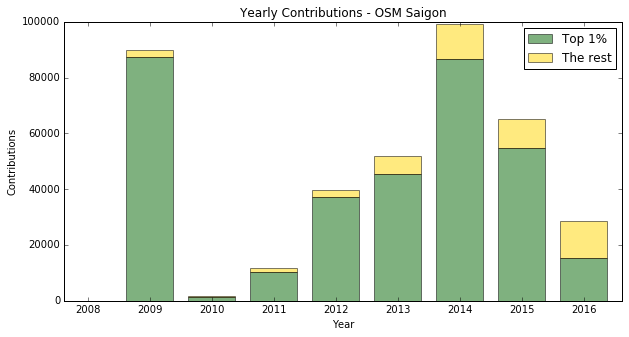

In [31]:
# Create the general blog and the "subplots"
%matplotlib inline
f, ax1 = plt.subplots(1, figsize=(10,5))
bar_width = 0.75
bar_l = range(2008,2017) 
tick_pos = [i+(bar_width/2) for i in bar_l] 

# Create the top_contributors graph
ax1.bar(bar_l, yearly_top_contributions['contributions'], width=bar_width, 
        label='Top 1%', alpha=0.5, color='darkgreen')

# Create the non_top_contributors graph, position it above the top_contributors
ax1.bar(bar_l, yearly_not_top_contributions['contributions'], width=bar_width, 
        bottom=yearly_top_contributions['contributions'], label='The rest', alpha=0.5, color='gold')

# set the x ticks with names of years
plt.xticks(tick_pos, range(2008,2017))

# Set the label and legends
ax1.set_ylabel("Contributions")
ax1.set_xlabel("Year")
ax1.set_title("Yearly Contributions - OSM Saigon")
plt.legend(loc='upper right')

The top 1% contributors contribute up to 87% of all contents. And they are human, not bots.
 
And no, that is a very bad news:
    - It's good and all, when the top contributors contribute. But what happened, when they stopped? Well, nothing. Nothing happened, because there was no one to make it happened. Look at 2010, contributions dropped to almost nothing.
    - Open Street Map can be so much more accurate than Google's and Bing's, because it relies on "on the ground" volunteers. So it's gonna be hurted the most, when volunteer contributions drop.
    - The numbers of volunteers and contributions from non-top-contributors are increasing steadily over the years, which is good, but not good enough. The map of Saigon, let alone Vietnam, are still severely lacking.
    
To remain relevant, OSM Saigon needs more contributors. There are lots of ways:
    - Type of contributors: Why relies on human, when you could use machine? We're now in the era of robots (delivery bots, both ground and air). We could now employ thousands of flying bots to do real-time aerial mapping, world-wide. This, however, also mean that Google's and Bing's could do the same thing. And it's gonna be difficult, to prevail against them, given their huge advantageous in technology and capital.
    - Reduce barriers of entry: No more GPS device, no more pens and paper, now, with just a smartphone, and an app, plug-n-play, anyone with a smartphone could become a contributor now.
    - Incentives: There are still things that only human could do. So a special incentive system would go a long way:
          + A leader board that honour top contributors.
          + Some sort of personalized page, where people can quote or show off their contributions.